In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *

# Setting Things Up

In [2]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]
        
         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample 
            nn.GroupNorm(8, 2 * n_feat), # normalize                        
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]
        
        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)
        
        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
            
        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


In [3]:
# hyperparameters

# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
device = torch.device("mps" if torch.backends.mps.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 10 # context vector is of size 10
height = 28 # 16x16 image
save_dir = './weights/'
chan = 1

# training hyperparameters
batch_size = 128
n_epoch = 32
lrate=1e-3

In [4]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [5]:
# construct model
nn_model = ContextUnet(in_channels=chan, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [6]:
nn_model.load_state_dict(torch.load("./true/MNIST_260.pth"))

<All keys matched successfully>

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
net.load_state_dict(torch.load("./weights/MNIST_Reco.pth"))

<All keys matched successfully>

In [9]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
@torch.no_grad()
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [10]:
save_rate=20

In [11]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, chan, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    intermediate.append(samples.detach().cpu().numpy())
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [12]:
timesteps = 1000

In [13]:
save_rate = 20

# Speciation

In [14]:
@torch.no_grad()
def go_in(timesteps):
    fi=dict()
    for x in range(0,timesteps+1,20):
        fi[x]=0
    
    for o in range (4):
        samples, intermediate = sample_ddpm(25)
        samples = samples.cpu()
        _, samples_class = torch.max(net(samples), 1)

        for step in range(timesteps,-1,-20):
            clones = torch.Tensor(intermediate [int(timesteps/save_rate) - int(step/save_rate)]).to(device)
            if step % 100 == 0:
                print(step, "-->", end=" ")

            for i in range(step, 0, -1):
                # reshape time tensor
                t = torch.tensor([i / timesteps])[:, None, None, None].to(device)
                # sample some random noise to inject back in. For i = 1, don't add back in noise
                z = torch.randn_like(clones) if i > 1 else 0
                eps = nn_model(clones, t)    # predict noise e_(x_t,t)
                clones = denoise_add_noise(clones, i, eps, z)
            # Now look at the resulting classes
            clones = clones.cpu()
            _, clone_class = torch.max(net(clones), 1)
            clones = clones.to(device)
            
        
            fi[step] += int(sum(clone_class == samples_class)) 
        print("\n")
    for x in fi:
        fi[x] /= 100

    return fi



In [22]:
@torch.no_grad()
def go_in(timesteps):
    fi=dict()
    for x in range(0,timesteps+1,20):
        fi[x]=0
    
    for o in range (1):
        samples, intermediate = sample_ddpm(25)
        samples = samples.cpu()
        _, samples_class = torch.max(net(samples), 1)

        for step in range(timesteps,-1,-20):
            clone_1 = torch.Tensor(intermediate [int(timesteps/save_rate) - int(step/save_rate)]).to(device)
            clone_2 = torch.Tensor(intermediate [int(timesteps/save_rate) - int(step/save_rate)]).to(device)
            if step % 100 == 0:
                print(step, "-->", end=" ")

            for i in range(step, 0, -1):
                # reshape time tensor
                t = torch.tensor([i / timesteps])[:, None, None, None].to(device)
                # sample some random noise to inject back in. For i = 1, don't add back in noise
                z_1,z_2 = torch.randn_like(clone_1) if i > 1 else 0, torch.randn_like(clone_2) if i > 1 else 0
                eps_1 = nn_model(clone_1, t)    # predict noise e_(x_t,t)
                eps_2 = nn_model(clone_2, t)
                clone_1 = denoise_add_noise(clone_1, i, eps_1, z_1)
                clone_2 = denoise_add_noise(clone_2, i, eps_2, z_2)
            # Now look at the resulting classes
            clone_1, clone_2 = clone_1.cpu(), clone_2.cpu()
            _, clone_class_1 = torch.max(net(clone_1), 1)
            _, clone_class_2 = torch.max(net(clone_2), 1)
            clone_1 = clone_1.to(device)
            clone_2 = clone_2.to(device)
            
        
            fi[step] += int(sum(clone_class_1 == clone_class_2)) 
        print("\n")
    for x in fi:
        fi[x] /= 100

    return fi

            # Check if resulting class is the same as sample[x]
            # If yes (or no), update average 


In [15]:
a = go_in(timesteps)

1000 --> timestep   10900 --> 800 --> 700 --> 600 --> 500 --> 400 --> 300 --> 200 --> 100 --> 0 --> 

1000 --> timestep   10900 --> 800 --> 700 --> 600 --> 500 --> 400 --> 300 --> 200 --> 100 --> 0 --> 

1000 --> timestep   10900 --> 800 --> 700 --> 600 --> 500 --> 400 --> 300 --> 200 --> 100 --> 0 --> 

1000 --> timestep   10900 --> 800 --> 700 --> 600 --> 500 --> 400 --> 300 --> 200 --> 100 --> 0 --> 



In [24]:
N = 2

#Prendine uno ogni N
mask = []
for i in range(len(a)):
    if i%N == 0:
        mask.append(True)
    else:
        mask.append(False)


/var/folders/cd/sr6rtt2j1rqdn0jdyblt3ztm0000gn/T/ipykernel_51242/1051409440.py:13: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k*(x-x0))) #+ 0.5


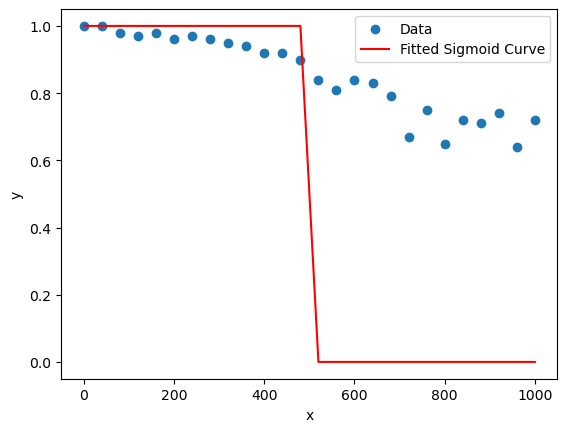

In [27]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import expit  # Logistic function
import matplotlib.pyplot as plt
# Generate example data
new = np.array(list(a.keys()))[mask]
np.random.seed(0)
x_data = np.linspace(0, 1000, len(new))
y_data = np.array([a[x] for x in new]) #-0.5

# Define the sigmoidal function using scipy's expit (logistic) function
def sigmoid(x, L, x0, k):
    return L / (1 + np.exp(-k*(x-x0))) #+ 0.5


# Fit the sigmoidal function to the data
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0=[max(y_data), np.median(x_data),-1])

# Plot the original data
plt.scatter(x_data, y_data, label='Data')

# Plot the fitted sigmoid curve
x_fit = np.linspace(0, 1000, 1000)
plt.plot(x_data, sigmoid(x_data, *popt), 'r-', label='Fitted Sigmoid Curve')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


# Save / Load

In [21]:
import json

# Save dictionary to a JSON file
with open('mnist_22.json', 'w') as json_file:
    json.dump(a, json_file)


In [26]:
import json
# Load dictionary from the JSON file
with open('mnist_2.json', 'r') as json_file:
    b = json.load(json_file)

a = dict()
for x in b:
    a[int(x)] = b[x]

print(a)

{0: 1.0, 20: 1.0, 40: 1.0, 60: 0.99, 80: 0.98, 100: 0.98, 120: 0.97, 140: 0.98, 160: 0.98, 180: 0.99, 200: 0.96, 220: 0.95, 240: 0.97, 260: 0.96, 280: 0.96, 300: 0.95, 320: 0.95, 340: 0.87, 360: 0.94, 380: 0.95, 400: 0.92, 420: 0.9, 440: 0.92, 460: 0.95, 480: 0.9, 500: 0.86, 520: 0.84, 540: 0.83, 560: 0.81, 580: 0.85, 600: 0.84, 620: 0.81, 640: 0.83, 660: 0.85, 680: 0.79, 700: 0.75, 720: 0.67, 740: 0.75, 760: 0.75, 780: 0.82, 800: 0.65, 820: 0.79, 840: 0.72, 860: 0.71, 880: 0.71, 900: 0.68, 920: 0.74, 940: 0.63, 960: 0.64, 980: 0.68, 1000: 0.72}
